# All CVEs


In [1]:
# Import necessary libraries
from IPython.core.magic import register_cell_magic
from IPython.display import Markdown
import datetime
from datetime import date
import glob
import json
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from itables import init_notebook_mode, show
import itables.options as opt

# Initialize itables options
opt.dom = "tpir"
opt.style = "table-layout:auto;width:auto"
init_notebook_mode(all_interactive=True, connected=True)

# Register a custom cell magic for markdown
@register_cell_magic
def markdown(line, cell):
    return Markdown(cell.format(**globals()))

# Configure logging and warnings
logging.getLogger('matplotlib.font_manager').disabled = True
warnings.filterwarnings("ignore")

# Configure pandas display options
pd.set_option('display.width', 500)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 10)


In [2]:
def get_nested_value(entry, keys, default='Missing_Data'):
    try:
        for key in keys:
            entry = entry[key]
        return entry
    except (KeyError, IndexError):
        return default

row_accumulator = []
for filename in glob.glob('nvd.jsonl'):
    with open(filename, 'r', encoding='utf-8') as f:
        nvd_data = json.load(f)
        for entry in nvd_data:
            new_row = {
                'CVE': get_nested_value(entry, ['cve', 'id']),
                'Published': get_nested_value(entry, ['cve', 'published']),
                'AttackVector': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'attackVector']),
                'AttackComplexity': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'attackComplexity']),
                'PrivilegesRequired': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'privilegesRequired']),
                'UserInteraction': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'userInteraction']),
                'Scope': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'scope']),
                'ConfidentialityImpact': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'confidentialityImpact']),
                'IntegrityImpact': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'integrityImpact']),
                'AvailabilityImpact': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'availabilityImpact']),
                'BaseScore': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'baseScore'], '0.0'),
                'BaseSeverity': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'baseSeverity']),
                'ExploitabilityScore': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'exploitabilityScore']),
                'ImpactScore': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'impactScore']),
                'CWE': get_nested_value(entry, ['cve', 'weaknesses', 0, 'description', 0, 'value']),
                'Description': get_nested_value(entry, ['cve', 'descriptions', 0, 'value'], ''),
                'Assigner': get_nested_value(entry, ['cve', 'sourceIdentifier']),
                'Tag': get_nested_value(entry, ['cve', 'cveTags', 0, 'tags'], np.nan),
                'Status': get_nested_value(entry, ['cve', 'vulnStatus'], '')
            }
            row_accumulator.append(new_row)

nvd = pd.DataFrame(row_accumulator)
nvd = nvd[~nvd.Status.str.contains('Rejected')]
nvd['Published'] = pd.to_datetime(nvd['Published'])
nvd = nvd.sort_values(by=['Published'])
nvd = nvd.reset_index(drop=True)
nvd['BaseScore'] = pd.to_numeric(nvd['BaseScore']);
nvd['BaseScore'] = pd.to_numeric(nvd['BaseScore']);
nvd['BaseScore'] = nvd['BaseScore'].replace(0, np.nan);
nvdcount = nvd['Published'].count()
nvdunique = nvd['Published'].nunique()
startdate = date(2000, 1, 1)
enddate  = date.today()
numberofdays = enddate - startdate 
per_day = nvdcount/numberofdays.days

In [3]:
Markdown(f"Total Number of CVEs: **{nvd['CVE'].count()}**<br />Average CVEs Per Day: **{per_day.round(2)}**<br />Average CVSS Score: **{nvd['BaseScore'].mean().round(2)}**")

Total Number of CVEs: **281607**<br />Average CVEs Per Day: **30.31**<br />Average CVSS Score: **6.88**



## CVE Graphs

In [4]:
Month_Graph = nvd['Published'].groupby(nvd.Published.dt.to_period("M")).agg('count')
Year_Graph = nvd['Published'].groupby(nvd.Published.dt.to_period("Y")).agg('count')
Week_Graph = nvd['Published'].groupby(nvd.Published.dt.to_period("W")).agg('count')
Day_Graph = nvd['Published'].groupby(nvd.Published.dt.to_period("D")).agg('count')

### CVE Per Year Graph

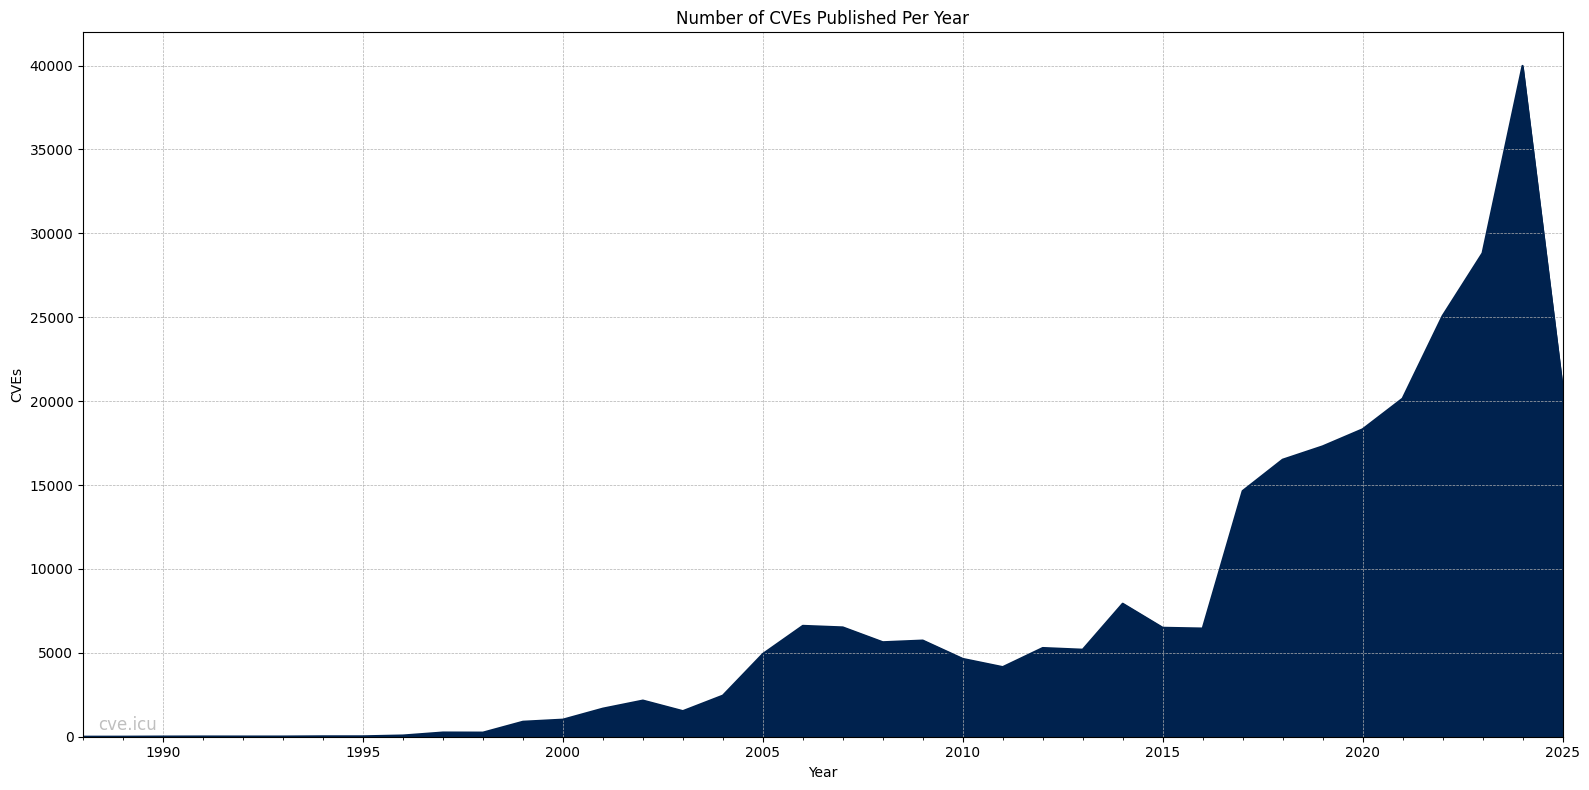

In [5]:
cg = Year_Graph.plot.area(colormap='cividis', figsize=(16, 8), title='Number of CVEs Published Per Year')
plt.grid(True, linestyle='--', linewidth=0.5)
cg.set_ylabel("CVEs")
cg.set_xlabel("Year")

# Add watermark
plt.text(0.01, 0.01, 'cve.icu', transform=cg.transAxes, fontsize=12, color='gray', alpha=0.5)

# Adjust layout and save the chart as a PNG file one directory up
plt.tight_layout()
plt.show()

### CVE Per Month Graph

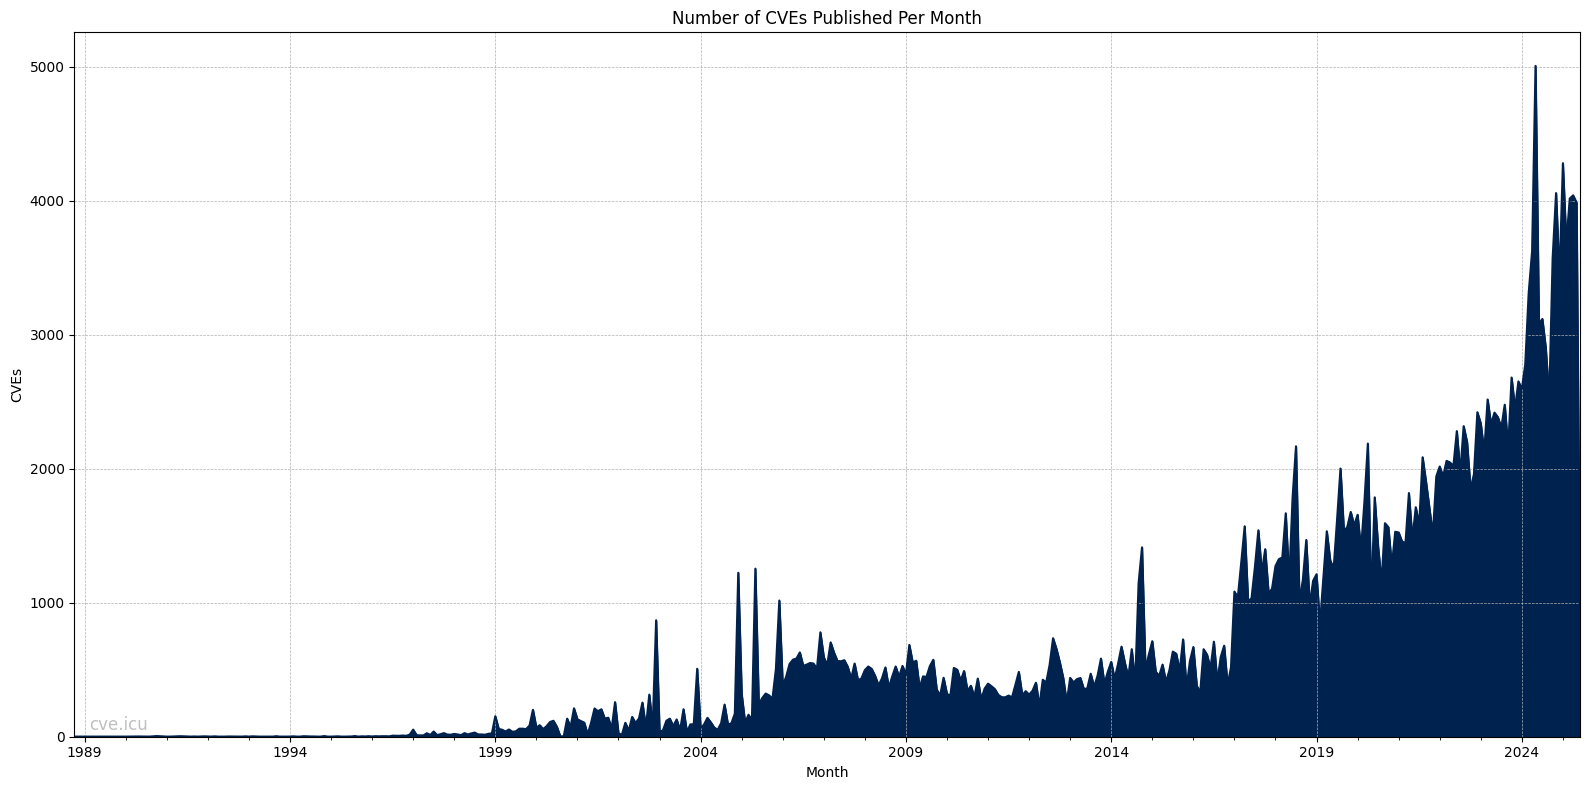

In [6]:
cg = Month_Graph.plot.area(colormap='cividis', figsize=(16, 8), title='Number of CVEs Published Per Month')
plt.grid(True, linestyle='--', linewidth=0.5)
cg.set_ylabel("CVEs")
cg.set_xlabel("Month")

# Add watermark
plt.text(0.01, 0.01, 'cve.icu', transform=cg.transAxes, fontsize=12, color='gray', alpha=0.5)

# Adjust layout and save the chart as a PNG file one directory up
plt.tight_layout()
plt.show()



### CVE Per Week Graph

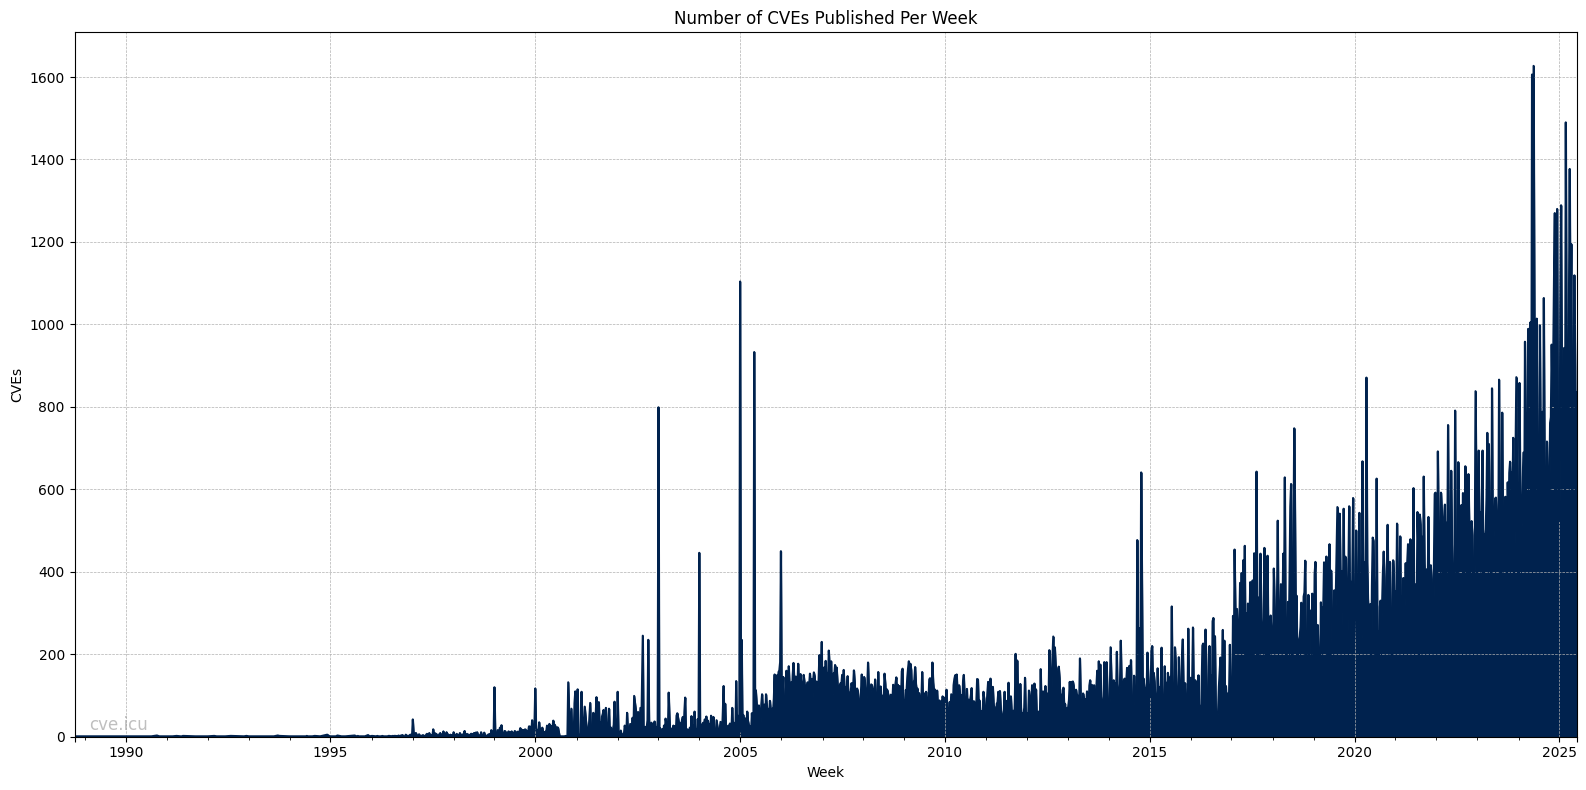

In [7]:
cg = Week_Graph.plot.area(colormap='cividis', figsize=(16, 8), title='Number of CVEs Published Per Week')
plt.grid(True, linestyle='--', linewidth=0.5)
cg.set_ylabel("CVEs")
cg.set_xlabel("Week")

# Add watermark
plt.text(0.01, 0.01, 'cve.icu', transform=cg.transAxes, fontsize=12, color='gray', alpha=0.5)

# Adjust layout and save the chart as a PNG file one directory up
plt.tight_layout()
plt.show()



### CVE Per Day Graph

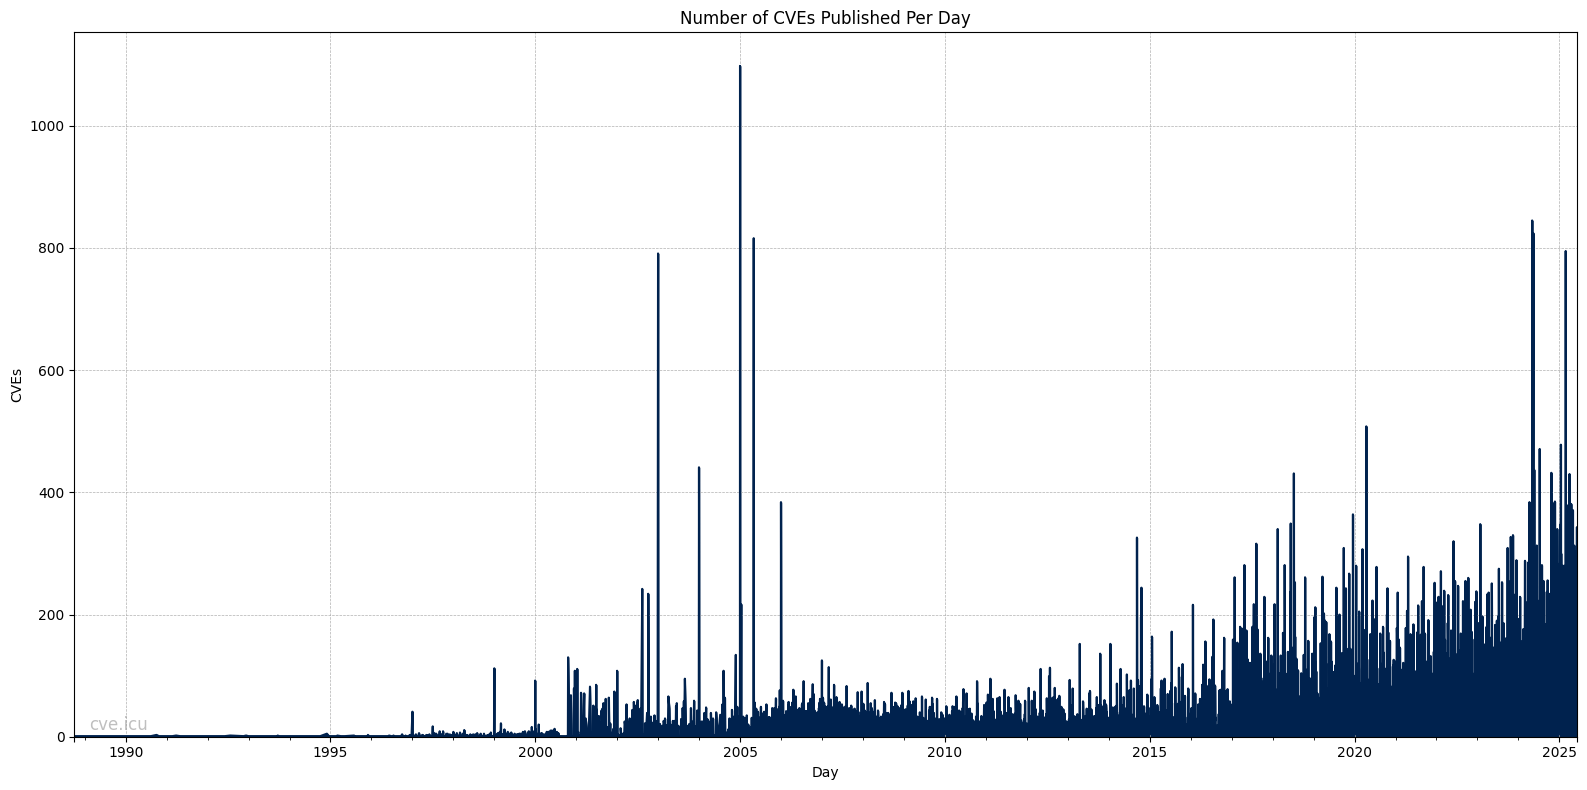

In [8]:
cg = Day_Graph.plot.area(colormap='cividis', figsize=(16, 8), title='Number of CVEs Published Per Day')
plt.grid(True, linestyle='--', linewidth=0.5)
cg.set_ylabel("CVEs")
cg.set_xlabel("Day")

# Add watermark
plt.text(0.01, 0.01, 'cve.icu', transform=cg.transAxes, fontsize=12, color='gray', alpha=0.5)

# Adjust layout
plt.tight_layout()
plt.show()


## CVSS Data

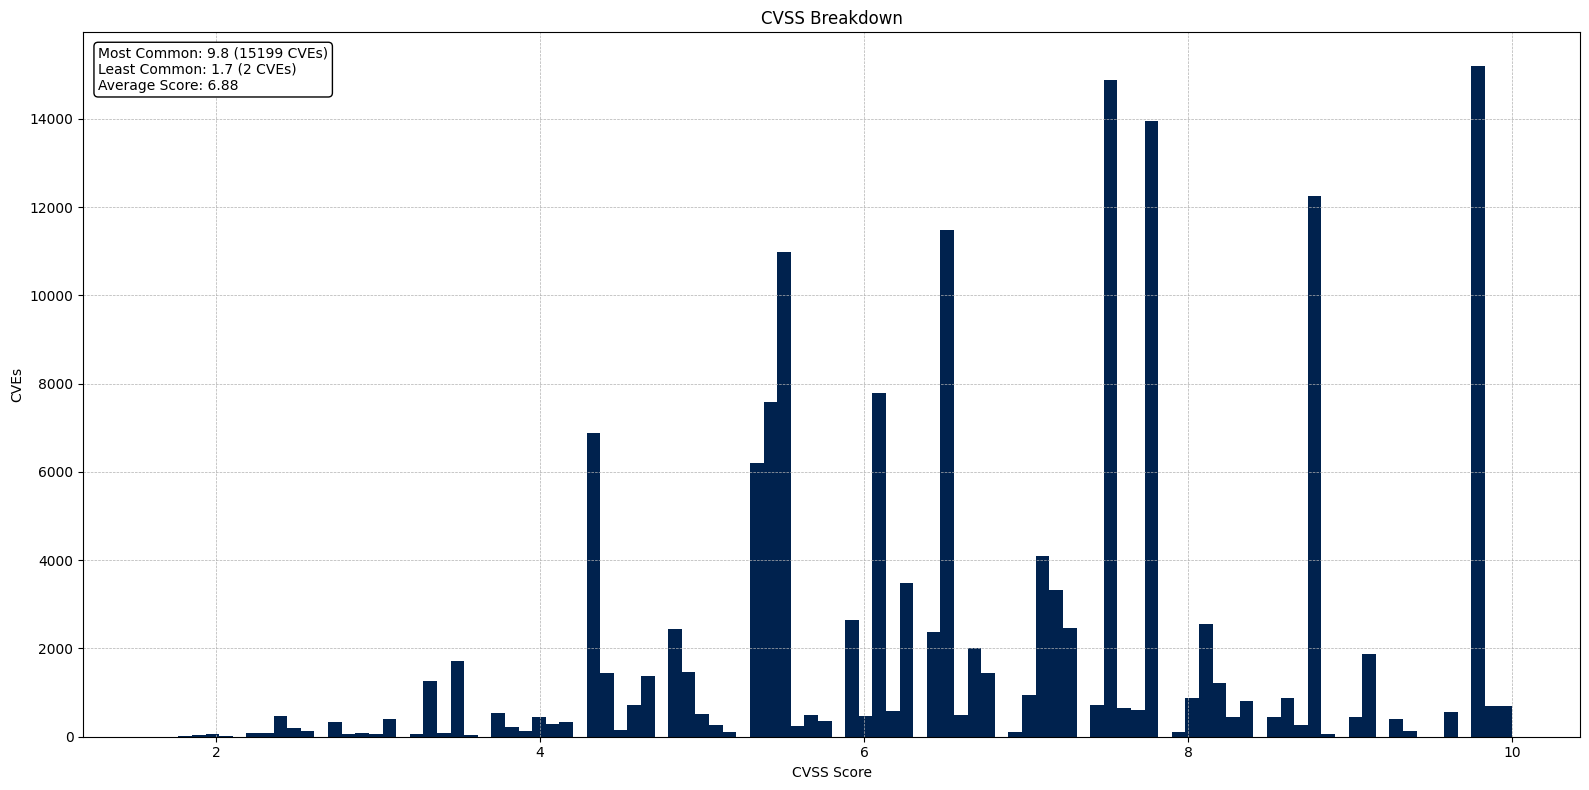

In [9]:

nvd['BaseScore'] = pd.to_numeric(nvd['BaseScore'])
nvd['BaseScore'] = nvd['BaseScore'].replace(0, np.nan)

# Plot the CVSS breakdown with 100 bins
cg = nvd['BaseScore'].plot(kind="hist", bins=100, title='CVSS Breakdown', colormap='cividis', figsize=(16, 8))
plt.grid(True, linestyle='--', linewidth=0.5)
cg.set_ylabel("CVEs")
cg.set_xlabel("CVSS Score")

# Find the most common, least common, and average CVSS scores
most_common_score = nvd['BaseScore'].mode()[0]
least_common_score = nvd['BaseScore'].value_counts().idxmin()
most_common_count = nvd['BaseScore'].value_counts().max()
least_common_count = nvd['BaseScore'].value_counts().min()
average_score = nvd['BaseScore'].mean().round(2)

# Add annotation for the most common, least common, and average CVSS scores
annotation_text = (f'Most Common: {most_common_score} ({most_common_count} CVEs)\n'
                   f'Least Common: {least_common_score} ({least_common_count} CVEs)\n'
                   f'Average Score: {average_score}')
plt.text(0.01, 0.98, annotation_text, transform=cg.transAxes, fontsize=10, color='black',
         verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))

# Adjust layout and save the chart as a PNG file one directory up
plt.tight_layout()
plt.show()

## CNA Data

### CNA Assigner Graph

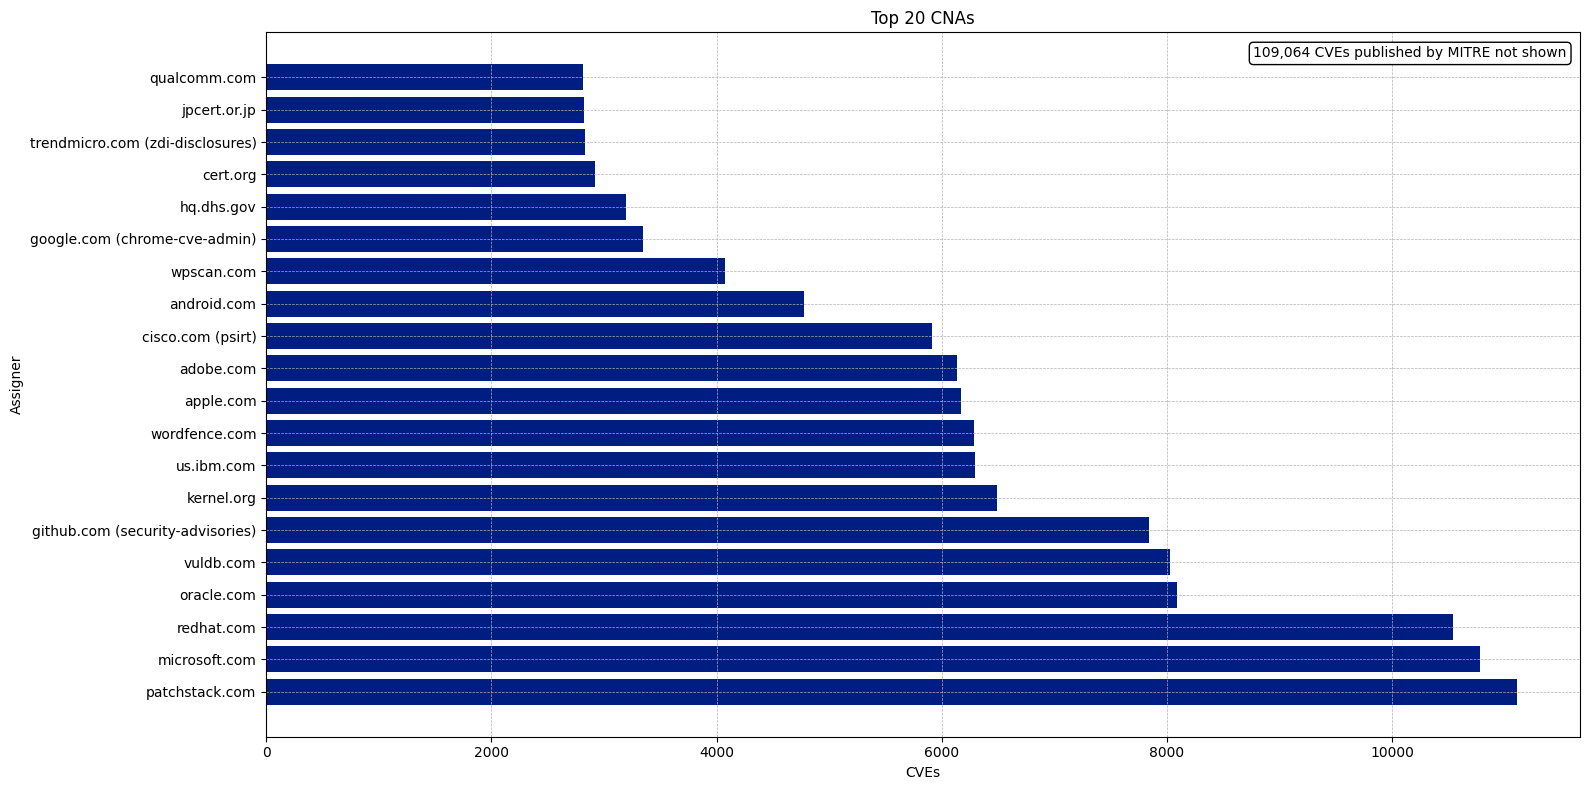

In [10]:
# Replace specific assigner ID with email
nvd['Assigner'].replace('416baaa9-dc9f-4396-8d5f-8c081fb06d67', 'cve@kernel.org', inplace=True)

# Extract domain names and check for uniqueness
nvd['Domain'] = nvd['Assigner'].apply(lambda x: x.split('@')[-1])
domain_counts = nvd['Domain'].value_counts()

# Modify Assigner column based on domain uniqueness
unique_domains = nvd.groupby('Domain')['Assigner'].nunique()
nvd['Assigner'] = nvd.apply(lambda x: x['Domain'] if unique_domains[x['Domain']] == 1 else f"{x['Domain']} ({x['Assigner'].split('@')[0]})", axis=1)

# Calculate frequency of assigners
nvd_frequency = nvd['Assigner'].value_counts().reset_index()
nvd_frequency.columns = ['Assigner', 'counts']
nvd_frequency = nvd_frequency[nvd_frequency.counts > 100].head(50)

# Calculate the number of CVEs published by mitre.org
mitre_cves = nvd_frequency[nvd_frequency['Assigner'].str.contains('mitre.org')]['counts'].sum()

# Remove mitre.org from the frequency list
nvd_frequency_no_mitre = nvd_frequency[~nvd_frequency.Assigner.str.contains('mitre.org')]
nvd_frequency_no_mitre = nvd_frequency_no_mitre[nvd_frequency_no_mitre.counts > 100].head(20)

# Plot the top 20 CNAs
plt.figure(figsize=(16, 8))
plt.barh("Assigner", "counts", data=nvd_frequency_no_mitre, color="#001d82")
plt.xlabel("CVEs")
plt.ylabel("Assigner")
plt.title("Top 20 CNAs")
plt.grid(True, linestyle='--', linewidth=0.5)

# Add a text box indicating mitre.org has been removed and the number of CVEs they published
textstr = f'{mitre_cves:,} CVEs published by MITRE not shown'
plt.text(0.99, 0.98, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))

# Adjust layout and show the chart
plt.tight_layout()
plt.show()



## CWE Data

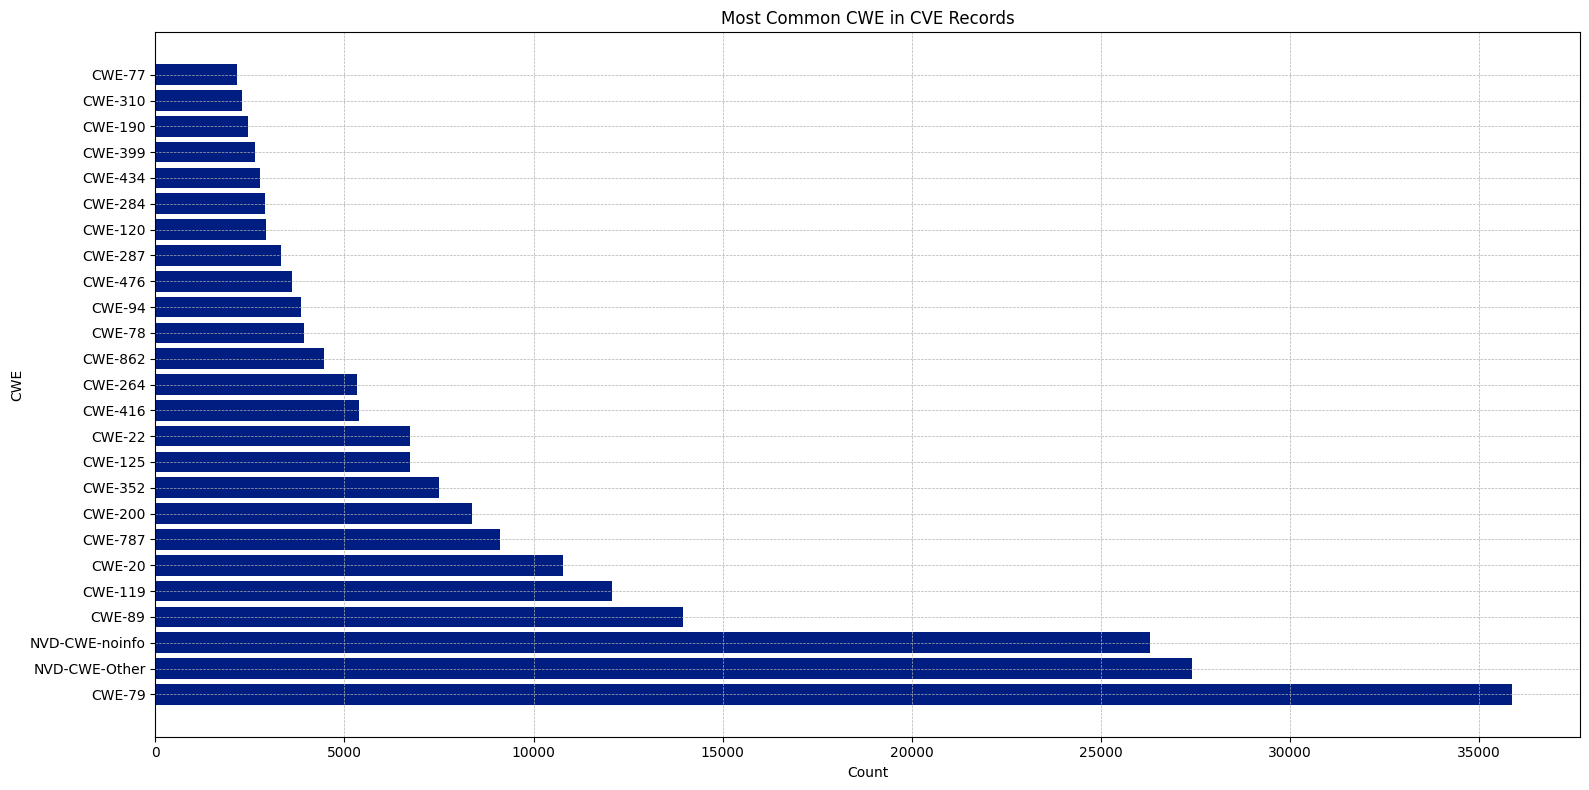

In [11]:
# Calculate frequency of CWEs
nvd_cwe = nvd['CWE'].value_counts().reset_index()
nvd_cwe.columns = ['CWE', 'counts']
nvd_cwe = nvd_cwe[~nvd_cwe.CWE.str.contains('Missing_')]
nvd_cwe = nvd_cwe[nvd_cwe.counts > 100].head(25)

# Plot the most common CWEs
plt.figure(figsize=(16, 8))
plt.barh("CWE", "counts", data=nvd_cwe, color="#001d82")
plt.xlabel("Count")
plt.ylabel("CWE")
plt.title("Most Common CWE in CVE Records")
plt.grid(True, linestyle='--', linewidth=0.5)

# Adjust layout and show the chart
plt.tight_layout()
plt.show()



## More CVE Data




### Top CNA Assigner

In [12]:
nvd_frequency.reset_index(drop=True, inplace=True)
show(nvd_frequency, scrollCollapse=True, paging=True)

Loading ITables v2.4.0 from the internet... (need help?)


### Top CWEs

In [13]:
nvd_cwe.reset_index(drop=True, inplace=True)
show(nvd_cwe, scrollCollapse=True, paging=True)

Loading ITables v2.4.0 from the internet... (need help?)






### CVEs By Year Published

In [14]:
# Convert the 'Published' column to datetime
nvd['Published'] = pd.to_datetime(nvd['Published'])

years = range(1980, 2030)
cve_counts = []

for year in years:
    count = len(nvd[nvd['Published'].dt.year == year])
    cve_counts.append({'Identifier': f'{year}', 'Count': count})

cve_df = pd.DataFrame(cve_counts)

# Filter out rows with a count of 0
cve_df = cve_df[cve_df['Count'] > 0]

# Reset the index
cve_df.reset_index(drop=True, inplace=True)

show(cve_df,  scrollCollapse=True, paging=False)

Loading ITables v2.4.0 from the internet... (need help?)





### CVEs By Identifier

In [15]:
years = range(1980, 2030)
cve_counts = []

for year in years:
    count = len(nvd[nvd['CVE'].str.contains(f'CVE-{year}-')])
    cve_counts.append({'Identifier': f'CVE-{year}', 'Count': count})

cve_df = pd.DataFrame(cve_counts)

# Filter out rows with a count of 0
cve_df = cve_df[cve_df['Count'] != 0]

# Reset the index
cve_df.reset_index(drop=True, inplace=True)

show(cve_df,  scrollCollapse=True, paging=False)

Loading ITables v2.4.0 from the internet... (need help?)


In [16]:
Markdown(f"This report is updated automatically every day, last generated on: **{datetime.datetime.now()}**")

This report is updated automatically every day, last generated on: **2025-06-08 20:07:02.172494**